In [1]:
using DataFrames
using Convex
using PyPlot
using ECOS
using LowRankModels
include("proxgrad.jl")
set_default_solver(ECOSSolver(verbose=0))

ECOS.ECOSSolver(Any[(:verbose,0)])

In [2]:
all09 = readtable("2009_new.csv");

In [3]:
classes=unique(all09[:BUILDING_CLASS_CATEGORY])

8-element DataArrays.DataArray{String,1}:
 "07  RENTALS - WALKUP APARTMENTS"   
 "13  CONDOS - ELEVATOR APARTMENTS"  
 "15  CONDOS - 2-10 UNIT RESIDENTIAL"
 "02  TWO FAMILY HOMES"              
 "03  THREE FAMILY HOMES"            
 "01  ONE FAMILY HOMES"              
 "12  CONDOS - WALKUP APARTMENTS"    
 "04  TAX CLASS 1 CONDOS"            

In [4]:
areas=unique(all09[:NEIGHBORHOOD])

244-element DataArrays.DataArray{String,1}:
 "ALPHABET CITY"            
 "CHELSEA"                  
 "CHINATOWN"                
 "CIVIC CENTER"             
 "CLINTON"                  
 "EAST VILLAGE"             
 "FASHION"                  
 "FINANCIAL"                
 "FLATIRON"                 
 "GRAMERCY"                 
 "GREENWICH VILLAGE-CENTRAL"
 "GREENWICH VILLAGE-WEST"   
 "HARLEM-CENTRAL"           
 ⋮                          
 "SILVER LAKE"              
 "SOUTH BEACH"              
 "STAPLETON"                
 "STAPLETON-CLIFTON"        
 "TODT HILL"                
 "TOMPKINSVILLE"            
 "TOTTENVILLE"              
 "TRAVIS"                   
 "WEST NEW BRIGHTON"        
 "WESTERLEIGH"              
 "WILLOWBROOK"              
 "WOODROW"                  

In [5]:
zips=unique(all09[:ZIP_CODE])

179-element DataArrays.DataArray{Int64,1}:
 10009
 10011
 10001
 10013
 10002
 10007
 10036
 10019
 10003
 10018
 10280
 10006
 10004
     ⋮
 10312
 10305
 10314
 10303
 10310
 10301
 10304
 10306
 10308
 10309
 10307
 10302

## neigbourhood to price per sqft dictionary

In [6]:
area_price_sqft=Dict([])

for i=1:length(areas)
    current_area=areas[i]
    this_area=all09[:NEIGHBORHOOD].==current_area
    area_prices=all09[this_area,:SALE_PRICE];
    area_sqft=all09[this_area,:GROSS_SQUARE_FEET];
    area_price_sqft[current_area]=sum(area_prices)/sum(area_sqft)
end

In [7]:
println(area_price_sqft["SOHO"])
println(area_price_sqft["CHINATOWN"])

1018.6077715374387
582.8182722678458


## building class to price per sqft dictionary

In [8]:
class_price_sqft=Dict([])

for i=1:length(classes)
    current_class=classes[i]
    this_class=all09[:BUILDING_CLASS_CATEGORY].==current_class
    class_prices=all09[this_class,:SALE_PRICE];
    class_sqft=all09[this_class,:GROSS_SQUARE_FEET];
    class_price_sqft[current_class]=sum(class_prices)/sum(class_sqft)
end

class_price_sqft

Dict{Any,Any} with 8 entries:
  "15  CONDOS - 2-10 UNIT RESIDENTIAL" => 632.594
  "02  TWO FAMILY HOMES"               => 230.329
  "01  ONE FAMILY HOMES"               => 297.465
  "12  CONDOS - WALKUP APARTMENTS"     => 454.304
  "04  TAX CLASS 1 CONDOS"             => 313.194
  "03  THREE FAMILY HOMES"             => 201.065
  "07  RENTALS - WALKUP APARTMENTS"    => 172.074
  "13  CONDOS - ELEVATOR APARTMENTS"   => 1071.89

## area_class_avg [neighborhood] [building class] = avg price of the category in the area 

In [9]:
area_class_avg=Dict([])

for i=1:length(areas)
    current_area=areas[i]
    this_area=all09[:NEIGHBORHOOD].==current_area
    area_rows=all09[this_area,:]
    area_class_avg[current_area]=Dict([])
    for c=1:length(classes)
        current_class=classes[c]
        this_class=area_rows[:BUILDING_CLASS_CATEGORY].==current_class
        group_prices=area_rows[this_class,:SALE_PRICE]
        group_sqft=area_rows[this_class,:GROSS_SQUARE_FEET]
        area_class_avg[current_area][current_class]=sum(group_prices)/sum(group_sqft)
    end
end


In [10]:
area_class_avg["CHELSEA"]

Dict{Any,Any} with 8 entries:
  "15  CONDOS - 2-10 UNIT RESIDENTIAL" => 964.162
  "02  TWO FAMILY HOMES"               => 887.944
  "01  ONE FAMILY HOMES"               => NaN
  "12  CONDOS - WALKUP APARTMENTS"     => NaN
  "04  TAX CLASS 1 CONDOS"             => NaN
  "03  THREE FAMILY HOMES"             => 1207.5
  "07  RENTALS - WALKUP APARTMENTS"    => 368.687
  "13  CONDOS - ELEVATOR APARTMENTS"   => 1360.83

In [11]:
area_class_avg["MIDTOWN EAST"]

Dict{Any,Any} with 8 entries:
  "15  CONDOS - 2-10 UNIT RESIDENTIAL" => 1769.52
  "02  TWO FAMILY HOMES"               => 727.953
  "01  ONE FAMILY HOMES"               => 1283.57
  "12  CONDOS - WALKUP APARTMENTS"     => NaN
  "04  TAX CLASS 1 CONDOS"             => NaN
  "03  THREE FAMILY HOMES"             => NaN
  "07  RENTALS - WALKUP APARTMENTS"    => 422.473
  "13  CONDOS - ELEVATOR APARTMENTS"   => 1036.36

# This is the X matrix !!

In [12]:
y=convert(Array,all09[:,:SALE_PRICE])

26799-element Array{Int64,1}:
  670509
 3500000
 1252452
  585000
  585000
  675250
 1221900
 1200000
  995000
 4750000
 3800000
 2000000
 2624000
       ⋮
  441000
  410000
  475000
  530000
  400000
  383383
  550000
  450100
  499999
  527500
  520000
  522500

In [13]:
n=length(all09[1])
d=17
X=zeros(n,d)
X=[X ones(n)] #add an offset

nbr_products=[]
class_products=[]
nbr_class_products=[]

for i=1:n
    nbr=all09[i,:NEIGHBORHOOD]
    class=all09[i,:BUILDING_CLASS_CATEGORY]
    size=all09[i,:GROSS_SQUARE_FEET]
    X[i,1]=area_price_sqft[nbr]*size
    X[i,2]=class_price_sqft[class]*size
    X[i,3]=area_class_avg[nbr][class]*size
    b=all09[i,:BOROUGH]
    X[i,3+b]=1 #dummy coding borough
    tax=all09[i,:TAX_CLASS_AT_TIME_OF_SALE]
    X[i,8+tax]=1 #dummy coding tax class
    X[i,13]=all09[i,:TOTAL_UNITS]
    X[i,14]=all09[i,:GROSS_SQUARE_FEET]
    X[i,15]=all09[i,:YEAR_BUILT]
    X[i,16]=area_price_sqft[all09[i,:NEIGHBORHOOD]]
    X[i,17]=class_price_sqft[all09[i,:BUILDING_CLASS_CATEGORY]]
    
    push!(nbr_products,X[i,1])
    push!(class_products,X[i,2])
    push!(nbr_class_products,X[i,3])
end

X

26799×18 Array{Float64,2}:
 1.84274e6  1.19075e6       1.17374e6  …  1920.0   266.292   172.074  1.0
 2.57238e6  1.66223e6       1.63849e6     1900.0   266.292   172.074  1.0
 4.09877e6  2.64856e6       2.61073e6     1920.0   266.292   172.074  1.0
 1.19832e5  4.82352e5       5.60106e5     1928.0   266.292  1071.89   1.0
 1.30483e5  5.25227e5       6.09894e5     1928.0   266.292  1071.89   1.0
 2.40995e5  5.72498e5       8.06132e5  …  1905.0   266.292   632.594  1.0
 3.42452e5  8.13516e5       1.14551e6     2007.0   266.292   632.594  1.0
 3.42452e5  8.13516e5       1.14551e6     2007.0   266.292   632.594  1.0
 3.93668e6  7.73904e5       2.98349e6     1910.0  1171.63    230.329  1.0
 3.64377e6  7.16322e5       2.76151e6     1910.0  1171.63    230.329  1.0
 3.68712e6  6.32751e5       3.8e6      …  1910.0  1171.63    201.065  1.0
 1.13871e7  1.67239e6       3.58327e6     1900.0  1171.63    172.074  1.0
 7.18795e6  1.05567e6       2.2619e6      1920.0  1171.63    172.074  1.0
 ⋮         

In [14]:
function plot_dots(x,y,label,color)
    # plot data points X and color according to y
    clf()
    hold(true)
    axis("on")
    n=length(y)
    xlabel(label)
    ylabel("actutal sale price")
    for i=1:5000
        plot(x[i], y[i], color)
    end

    # set figure limits
    ylim([10000,2000000])
    xlim([10000,2000000])
end

plot_dots (generic function with 1 method)

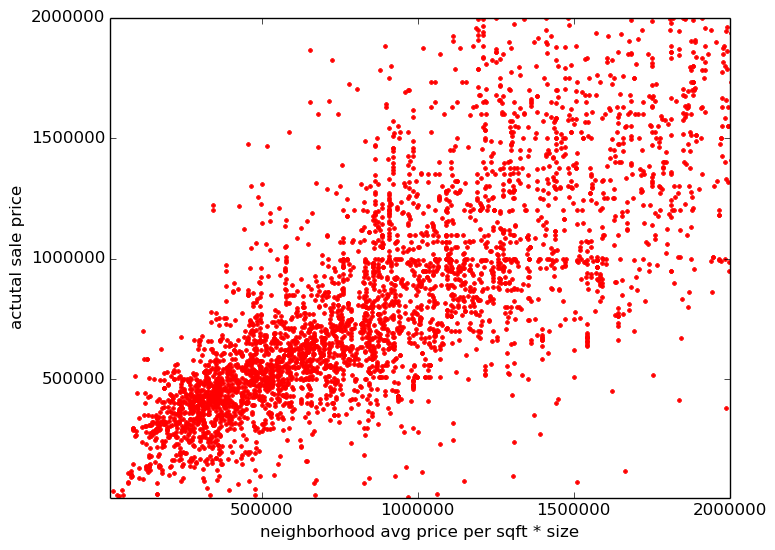

(10000,2000000)

In [15]:
plot_dots(nbr_products,y,"neighborhood avg price per sqft * size","r.")

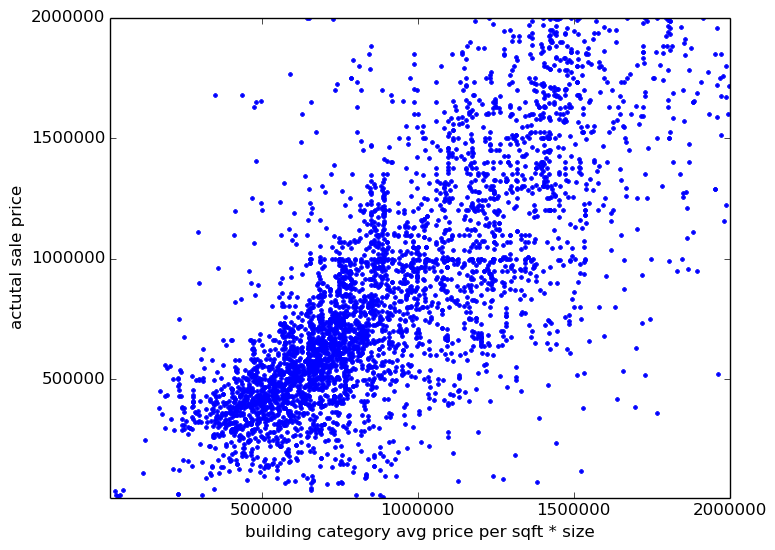

(10000,2000000)

In [16]:
plot_dots(class_products,y,"building category avg price per sqft * size","b.")

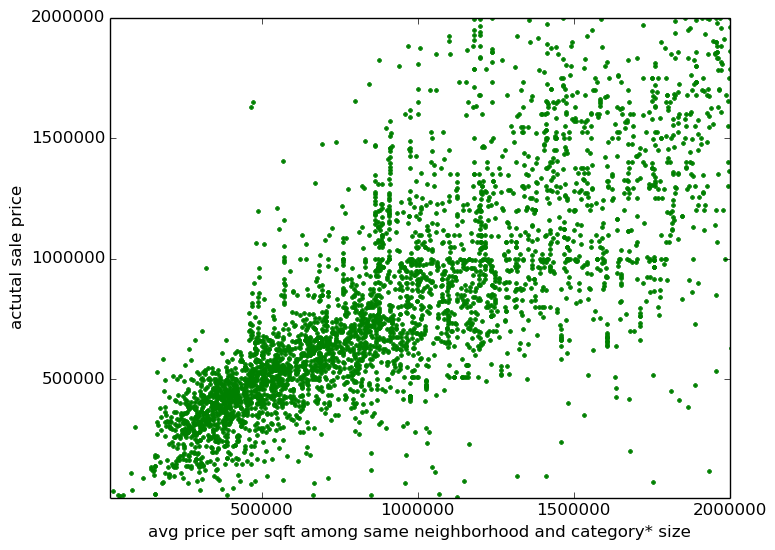

(10000,2000000)

In [17]:
plot_dots(nbr_class_products,y,"avg price per sqft among same neighborhood and category* size","g.")

## Break X in half into train and test set, same as y

In [36]:
flips=rand(n)
train_rows=flips.>=0.3
validate_rows=[i for i in 1:n if flips[i]>=0.1 && flips[i] < 0.3]
test_rows=flips.<0.1

X_train=X[train_rows,:]
X_validate=X[validate_rows,:]
X_test=X[test_rows,:]
y_train=y[train_rows]
y_validate=y[validate_rows]
y_test=y[test_rows]

2682-element Array{Int64,1}:
  1200000
  3800000
 19400000
  2087500
   680000
  1125000
 11847875
   755000
    11200
  1608835
  1374637
  1659747
  2291062
        ⋮
   350000
   285000
   575000
   465000
   600000
   497649
   455000
   320000
   730000
   420000
   455000
   450100

# 1.  L2 least squares

In [37]:
w=X_train\y_train

18-element Array{Float64,1}:
      -0.190801 
      -1.0791   
       1.42307  
  -46372.0      
      -1.79743e5
      -2.08326e5
      -2.3497e5 
 -212287.0      
      -4.36892e5
      -4.44806e5
       0.0      
       0.0      
   37000.4      
     107.929    
     774.68     
    -207.23     
     891.69     
      -8.81698e5

In [38]:
println("mean error squares on train set: ",mean(abs(y_train-X_train*w)))
println("mean error squares on test set: ", mean(abs(y_validate-X_validate*w)))

mean error squares on train set: 251257.88408371623
mean error squares on test set: 255271.5981094523


In [39]:
ys=[y_validate X_validate*w]

5361×2 Array{Float64,2}:
      1.25245e6       3.13317e6
 585000.0             1.38746e6
 995000.0             3.17339e6
      4.26647e6       2.22721e6
 750000.0             1.37541e6
 120000.0             1.87427e6
      5.04034e6       2.52613e6
 896060.0             1.41737e6
 993506.0             1.62063e6
 941881.0             1.41737e6
      1.535e6         1.62063e6
 913624.0             1.41737e6
      1.25e6          1.48047e6
      ⋮                        
 234000.0             2.68931e5
 196000.0             2.46427e5
 120000.0             2.64994e5
 300000.0             3.07654e5
 420000.0        367422.0      
 415000.0             3.62915e5
 340000.0             3.41187e5
 402000.0             3.53959e5
 445000.0             4.2873e5 
 400000.0             4.72483e5
 550000.0             5.01137e5
 499999.0             5.52444e5

In [40]:
mean(y_validate)

704148.7036000746

In [41]:
mean(X_validate*w)

707063.6451931306

In [42]:
correct=0
for i=1:length(y_validate)
    if(abs(ys[i,2]-ys[i,1])/ys[i,1]<=0.25)
        correct+=1
    end
end

correct/length(y_validate)

0.5316172355903749

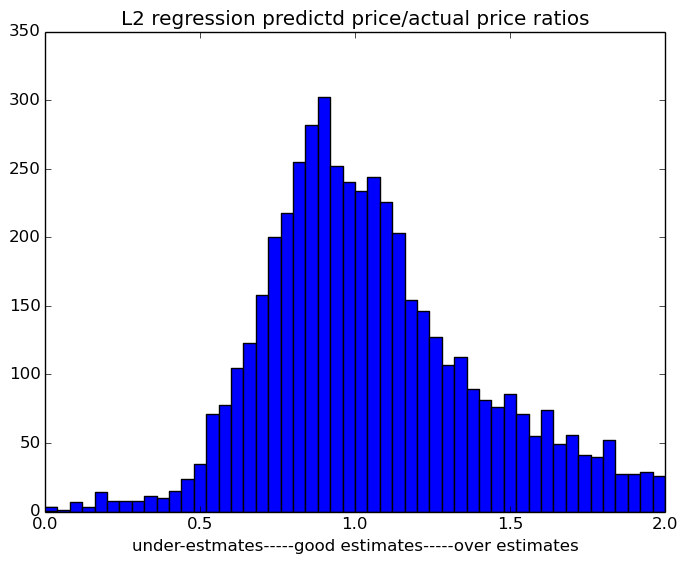

PyObject <matplotlib.text.Text object at 0x7f408cb59c90>

In [43]:
ratios=[dot(X_validate[i,:],w)/y_validate[i] for i=1:length(y_validate)]
plt[:hist](ratios,range=[0,2],bins=50)
xlabel("under-estmates-----good estimates-----over estimates")
title("L2 regression predictd price/actual price ratios")

# 2. L1 Regression

In [44]:
function L1(X,y)
    d = size(X,2)
    w = Variable(d)
    p = minimize(norm(X*w - y,1))
    solve!(p)
    return w.value
end

L1 (generic function with 1 method)

In [45]:
w_L1=L1(X_train,y_train)
println("l1 mean absolute error squares on train set: ",mean(abs(y_train-X_train*w_L1)))
println("l1 mean absolute error squares on test set: ", mean(abs(y_validate-X_validate*w_L1)))

l1 mean absolute error squares on train set: 214304.7699020079
l1 mean absolute error squares on test set: 213033.34387280655


In [79]:
w_L1

18×1 Array{Float64,2}:
      -0.0344121
      -0.456091 
       1.09549  
  -68674.1      
      -1.0074e5 
  -94775.8      
 -111119.0      
      -1.13861e5
      -1.76412e5
      -2.10505e5
       0.0      
       0.0      
   38785.7      
      10.2892   
     359.944    
    -232.834    
     353.169    
      -3.35364e5

In [80]:
println("l1 mean absolute error squares on test set: ", mean(abs(y_test-X_test*w_L1)))

l1 mean absolute error squares on test set: 199168.1962192062


In [83]:
ys=[y_test X_test*w_L1]
correct=0
for i=1:length(y_test)
    if(abs(ys[i,2]-ys[i,1])/ys[i,1]<=0.25)
        correct+=1
    end
end

correct/length(y_test)

0.615958240119314

In [46]:
pw_L1 = proxgrad(L1Loss(), ZeroReg(), X_train, y_train; maxiters = 10000, stepsize = 0.1)
println("l1 mean absolute error squares on train set: ",mean(abs(y_train-X_train*pw_L1)))
println("l1 mean absolute error squares on test set: ", mean(abs(y_validate-X_validate*pw_L1)))

l1 mean absolute error squares on train set: 215767.27881962762
l1 mean absolute error squares on test set: 207891.9596170333


In [50]:
ys=[y_validate X_validate*w_L1]
correct=0
for i=1:length(y_validate)
    if(abs(ys[i,2]-ys[i,1])/ys[i,1]<=0.25)
        correct+=1
    end
end

correct/length(y_validate)

0.5997015482186159

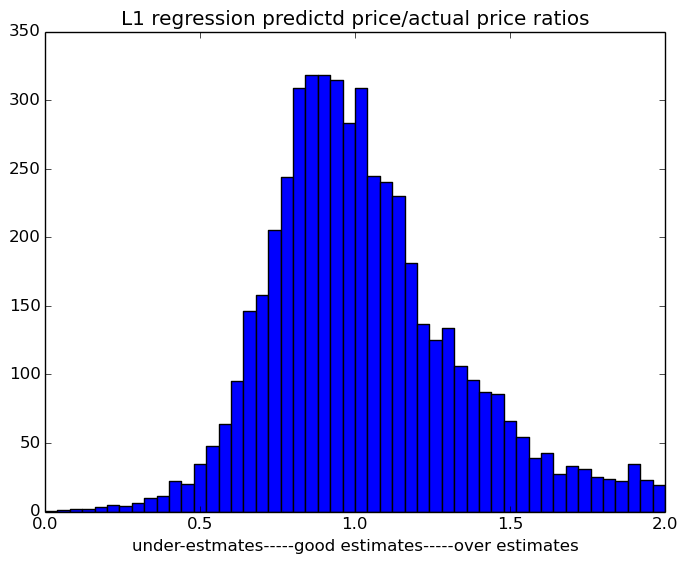

PyObject <matplotlib.text.Text object at 0x7f408c596490>

In [48]:
ratios=[dot(X_validate[i,:],w_L1)/y_validate[i] for i=1:length(y_validate)]
plt[:hist](ratios,range=[0,2],bins=50)
xlabel("under-estmates-----good estimates-----over estimates")
title("L1 regression predictd price/actual price ratios")

# 3. ridge and lasso regression

In [59]:
function ridge(X,y; λ=1)
    d = size(X,2)
    w = Variable(d)
    p = minimize(sumsquares(X*w - y) + λ*sumsquares(w))
    solve!(p)
    return w.value
end


function lasso(X,y; λ=1)
    d = size(X,2)
    w = Variable(d)
    p = minimize(sumsquares(X*w - y) + λ*norm(w,1))
    solve!(p)
    return w.value
end

lasso (generic function with 1 method)

In [60]:
w_ridge=ridge(X_train,y_train)
println("ridge mean error squares on train set: ",mean(abs(y_train-X_train*w_ridge)))
println("ridge mean error squares on test set: ", mean(abs(y_validate-X_validate*w_ridge)))

ridge mean error squares on train set: 271446.2421762278
ridge mean error squares on test set: 269484.7709685747


In [ ]:
pw_ridge = proxgrad(QuadLoss(), QuadReg(), X_train, y_train; maxiters = 100000, stepsize = 0.0001)
println("ridge mean absolute error squares on train set: ",mean(abs(y_train-X_train*pw_ridge)))
println("ridge mean absolute error squares on test set: ", mean(abs(y_validate-X_validate*pw_ridge)))

In [61]:
ys=[y_validate X_validate*w_ridge]
correct=0
for i=1:length(y_validate)
    if(abs(ys[i,2]-ys[i,1])/ys[i,1]<=0.25)
        correct+=1
    end
end

correct/length(y_validate)

0.5127774668905055

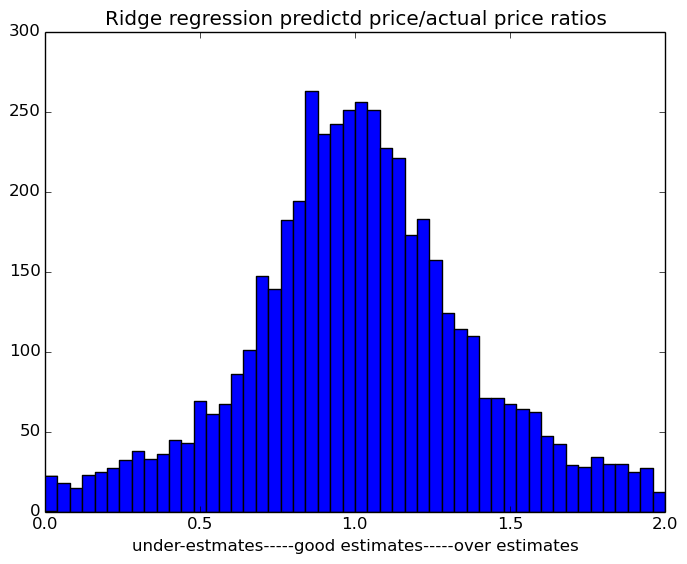

PyObject <matplotlib.text.Text object at 0x7f409621c510>

In [62]:
ratios=[dot(X_validate[i,:],w_ridge)/y_validate[i] for i=1:length(y_validate)]
plt[:hist](ratios,range=[0,2],bins=50)
xlabel("under-estmates-----good estimates-----over estimates")
title("Ridge regression predictd price/actual price ratios")

In [63]:
w_lasso=lasso(X_train,y_train)
println("lasso mean error squares on train set: ",mean(abs(y_train-X_train*w_lasso)))
println("lasso mean error squares on test set: ", mean(abs(y_validate-X_validate*w_lasso)))

lasso mean error squares on train set: 288793.58149726683
lasso mean error squares on test set: 292881.585636593


In [ ]:
pw_lasso = proxgrad(QuadLoss(), OneReg(), X_train, y_train; maxiters = 100000, stepsize = 0.0001)
println("lasso mean absolute error squares on train set: ",mean(abs(y_train-X_train*pw_lasso)))
println("lasso mean absolute error squares on test set: ", mean(abs(y_validate-X_validate*pw_lasso)))

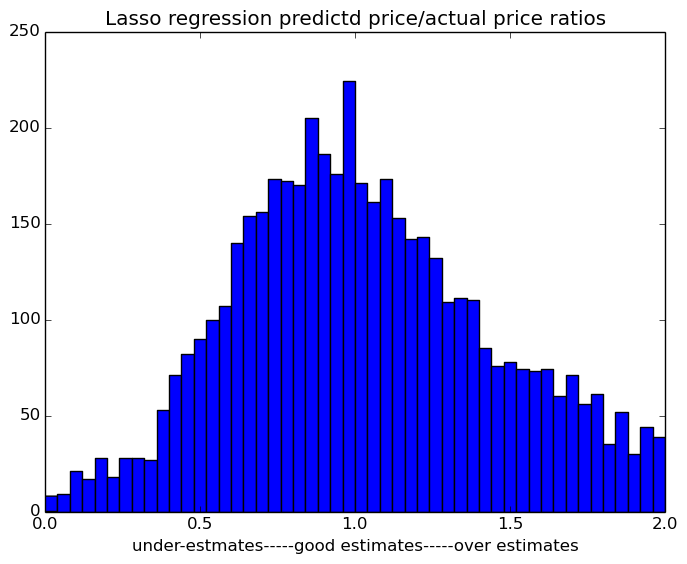

PyObject <matplotlib.text.Text object at 0x7f409689b650>

In [64]:
ratios=[dot(X_validate[i,:],w_lasso)/y_validate[i] for i=1:length(y_validate)]
plt[:hist](ratios,range=[0,2],bins=50)
xlabel("under-estmates-----good estimates-----over estimates")
title("Lasso regression predictd price/actual price ratios")

In [65]:
ys=[y_validate X_validate*w_lasso]
correct=0
for i=1:length(y_validate)
    if(abs(ys[i,2]-ys[i,1])/ys[i,1]<=0.25)
        correct+=1
    end
end

correct/length(y_validate)

0.4021637754150345

# 4. huber regression

In [ ]:
function huberloss(X,y,w)
    sum=0
    for i=1:length(y)
        z=y[i]-w'*X[i]
        if abs(z)<=1
            sum+=0.5*z^2
        else
            sum+=(abs(z)-0.5)
        end
    end
    return sum
end    

function huber(X,y)
    d = size(X,2)
    w = Variable(d)
    p = minimize(huberloss(X,y,w))
    solve!(p)
    return w.value
end

In [66]:
wHuber = proxgrad(HuberLoss(), QuadReg(), X_train, y_train; maxiters = 20000, stepsize = 0.01)

18-element Array{Float64,1}:
  0.000398671
  0.0249249  
  0.936915   
 -6.02157e-6 
  4.65068e-6 
  1.1959e-5  
  1.69398e-5 
  5.29258e-6 
  3.44319e-5 
 -1.61146e-6 
  0.0        
  0.0        
  4.54418e-5 
  0.0145863  
  0.0642611  
  0.000310649
  0.00498864 
  3.28205e-5 

In [67]:
println("Huber mean error squares on train set: ",mean(abs(y_train-X_train*wHuber)))
println("Huber mean error squares on test set: ", mean(abs(y_validate-X_validate*wHuber)))

Huber mean error squares on train set: 215758.07858569146
Huber mean error squares on test set: 207884.5258933286


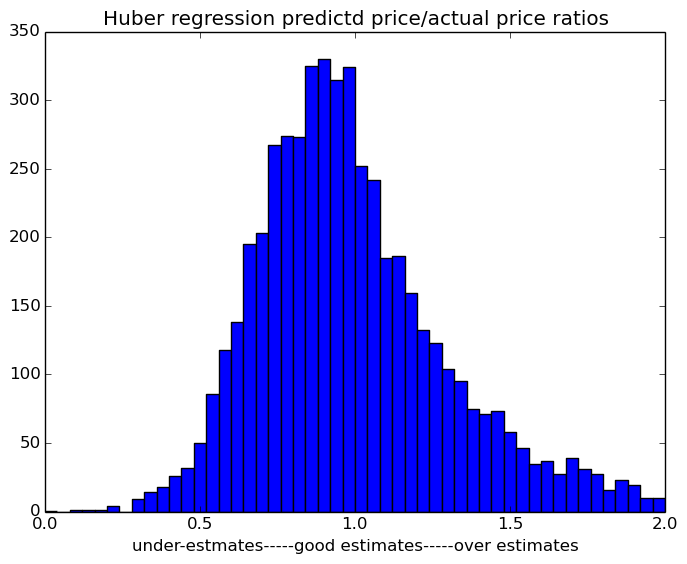

PyObject <matplotlib.text.Text object at 0x7f4093b96c10>

In [68]:
ratios=[dot(X_validate[i,:],wHuber)/y_validate[i] for i=1:length(y_validate)]
plt[:hist](ratios,range=[0,2],bins=50)
xlabel("under-estmates-----good estimates-----over estimates")
title("Huber regression predictd price/actual price ratios")

In [69]:
ys=[y_validate X_validate*wHuber]
correct=0
for i=1:length(y_validate)
    if(abs(ys[i,2]-ys[i,1])/ys[i,1]<=0.25)
        correct+=1
    end
end

correct/length(y_validate)

0.5804887147920165

In [70]:
wHuber = proxgrad(HuberLoss(), ZeroReg(), X_train, y_train; maxiters = 20000, stepsize = 0.01)
println("Huber mean error squares on train set: ",mean(abs(y_train-X_train*wHuber)))
println("Huber mean error squares on test set: ", mean(abs(y_validate-X_validate*wHuber)))

Huber mean error squares on train set: 215756.05919845687
Huber mean error squares on test set: 207882.77934718327


In [73]:
ys=[y_validate X_validate*wHuber]
correct=0
for i=1:length(y_validate)
    if(abs(ys[i,2]-ys[i,1])/ys[i,1]<=0.25)
        correct+=1
    end
end

correct/length(y_validate)

0.5804887147920165

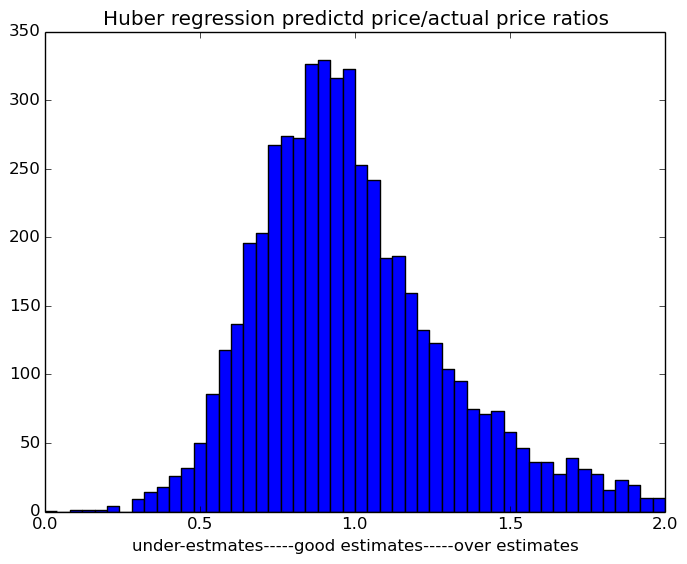

PyObject <matplotlib.text.Text object at 0x7f409643b850>

In [72]:
ratios=[dot(X_validate[i,:],wHuber)/y_validate[i] for i=1:length(y_validate)]
plt[:hist](ratios,range=[0,2],bins=50)
xlabel("under-estmates-----good estimates-----over estimates")
title("Huber regression predictd price/actual price ratios")

In [76]:
wHuber = proxgrad(HuberLoss(), OneReg(), X_train, y_train; maxiters = 20000, stepsize = 0.01)
println("Huber mean error squares on train set: ",mean(abs(y_train-X_train*wHuber)))
println("Huber mean error squares on test set: ", mean(abs(y_validate-X_validate*wHuber)))

Huber mean error squares on train set: 215757.7386545434
Huber mean error squares on test set: 207884.20380353968


In [77]:
ys=[y_validate X_validate*wHuber]
correct=0
for i=1:length(y_validate)
    if(abs(ys[i,2]-ys[i,1])/ys[i,1]<=0.25)
        correct+=1
    end
end

correct/length(y_validate)

0.5804887147920165

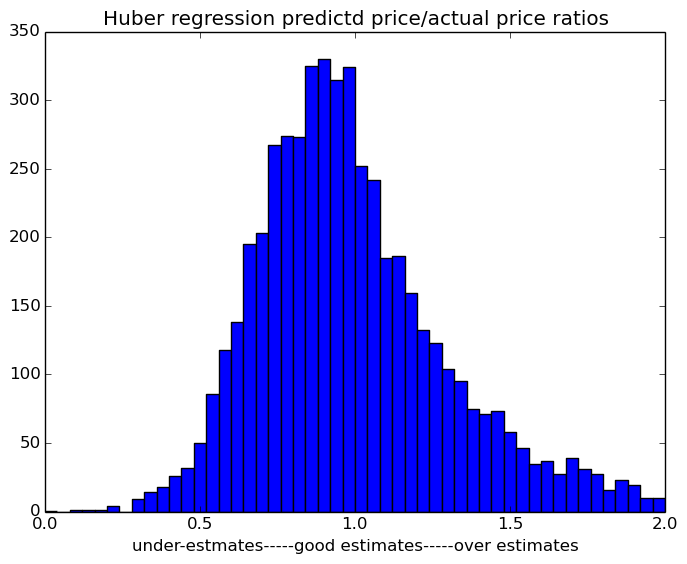

PyObject <matplotlib.text.Text object at 0x7f4093a9d910>

In [78]:
ratios=[dot(X_validate[i,:],wHuber)/y_validate[i] for i=1:length(y_validate)]
plt[:hist](ratios,range=[0,2],bins=50)
xlabel("under-estmates-----good estimates-----over estimates")
title("Huber regression predictd price/actual price ratios")